In [22]:
# Reinforcment Learning with Foirier/Polynomial State Weighted Q Basis for Homogeus Multi Component Maitenance
# By Joseph Wittrock

# Enviroment/Training code adapted from:
# https://pytorch.org/rl/stable/tutorials/torchrl_envs.html
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# The enviroment is composed of n components with m condition states. Each component degrades each step according to its degredation transition matrix. 
# The actions to the enviroment are 0 for do nothing, or 1 for repair.
# Only k components can be repaired at a time, and the repair cost is proportional to the number of components repaired.
# If a component is in a failed state, it will have a failure cost no matter what action is taken. (Though I want to change how this works for multiperiod adaptation)
# The goal is to maximize the reward over a fixed number of steps, reward is negative for repair costs and failure costs.

# The enviroment is written using TorchRL and TensorDict for efficient paralell computation on a cuda enabled GPU.

# The state space is reduced by considering the distrobution of the components in each condition state, rather than the condition state of each component.
# This condenses the state space to m states.

# To generalize the action space we search for an "equitable" policy. i.e. a component in worse condition is always repaired before a component in better condition.
# This reduces the action space to k actions.

# For large values of m, a traditional deep Q network would not generalize well, as there are too many output neurons.
# Instead, we use a basis of continuous valued functions over [0,1], and map the action space to i \mapsto i/k for i in [0,k]. 
# Note when i=0, no components are repaired, and when i=k, all components are repaired, so there are k+1 actions in total.

# The degrees of approximation determine the output nodes for the neural network, then the output is dot producted with the basis functions evaluated at the precalculated action domain points.
# This allows for scale free computation for increasing values of the repair constraint.

In [23]:
from typing import Optional

from matplotlib import pyplot as plt # for plotting
import numpy as np # for cpu based computation
import torch # for efficient (gpu) computation and automatic differentiation
from tqdm import tqdm # for progress bars
from tensordict import TensorDict, TensorDictBase # for handling dictionaries of tensors in a pytorch friendly way, e.g. for batched data
from torch import nn # for neural networks
import torch.optim as optim # for optimizers
import torch.nn.functional as F # for activation functions
from torch.utils.tensorboard import SummaryWriter # for logging to tensorboard


# TorchRL
from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec # for defining the shape and type of data [Legacy]
from torchrl.data import Bounded, Composite, Unbounded # for defining the shape and type of data
from torchrl.envs import (
    CatTensors, # Concatenate tensors
    EnvBase, # Tensordict based env
    Transform, # Transform for envs
)
from torchrl.envs.transforms.transforms import _apply_to_composite # for applying a transform to a composite spec
from torchrl.envs.utils import check_env_specs, step_mdp # for checking env specs and stepping through an MDP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # enable cuda if available 
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [24]:
######################
#                    #
#   HYPERPARAMETERS  #
#                    #
######################

# Environment parameters
N_COMPONENTS = 1000 # number of components in each enviroment
MAX_REPAIR_CONSTRAINT = 50 # Maximum number of components that can be repaired in a single step
EPISODE_LENGTH = 128 # number of steps in each episode
STEP_BATCH_SIZE = 128 # number of environments to be executed in paralell
# - Cost parameters
# REPAIR_COST = 10.0 # cost per repair action taken each step
# FAILURE_COST = 20.0 # cost per maximum state (failed state) component each step
REWARD_BLEND = 0.6 # weight for blending orm costs and utility

# Optimization parameters
OPTIMIZATION_BATCH_SIZE = 64 * EPISODE_LENGTH # number of transitions to be used used in each optimization batch
BUFFER_SIZE = 1 * STEP_BATCH_SIZE * EPISODE_LENGTH # number of transitions to be stored in the memory replay buffer
OPTIMIZATION_PASSES = 1 # number of optimization passes to be made in each step
GAMMA = 0.98 # reward discount factor \in [0, 1]
TAU = 1e-2 # soft target network learning rate. \in [0, 1]
LR = 1e-2 # learning rate for policy network. \in [0, 1]
N_EPISODES = 100
EPOCHS = N_EPISODES * EPISODE_LENGTH  # number of epochs to train the policy network
# - Entropy parameters
ENTROPY_START = 0.5 # initial entropy value for random actions
ENTROPY_END = 0.15  # entropy value for random actions
ENTROPY_DECAY = 1_000  # entropy decay rate 
# - Agent Network parameters
BASIS =   "polynomial" # "fourier" #
N_DEEP_NODES = 32 # number of nodes in the deep network
DEGREE_APPROXIMATION = 3 # basis elements to be generated for action value approximation



In [25]:
###### Generate Other Parameters ######

# evaluate basis functions at every relevant action
# a = k / MAX_REPAIR_CONSTRAINT \in [0, 1] 
# for k \in { 0, 1, 2, ...,  MAX_REPAIR_CONSTRAINT }
basis_switch = { 
    "polynomial": torch.tensor([
        [ (n / MAX_REPAIR_CONSTRAINT )**k for n in range(MAX_REPAIR_CONSTRAINT + 1) ] 
        for k in range(DEGREE_APPROXIMATION)
    ], dtype=torch.float32),
    "fourier": torch.tensor([
        [np.cos(1 * np.pi * k * n / MAX_REPAIR_CONSTRAINT) for n in range(MAX_REPAIR_CONSTRAINT + 1)]
        for k in range(DEGREE_APPROXIMATION)
    ], dtype=torch.float32),
    }
basis = basis_switch[ BASIS ]


def get_basis(degree: int, max_repair_constraint: int, basis_type: str = "polynomial") -> torch.Tensor:
    if basis_type == "polynomial":
        return torch.tensor([
            [ (n / max_repair_constraint )**k for n in range(max_repair_constraint + 1) ] 
            for k in range(degree)
        ], dtype=torch.float32)
    elif basis_type == "fourier":
        return torch.tensor([
            [np.cos(1 * np.pi * k * n / max_repair_constraint) for n in range(max_repair_constraint + 1)]
            for k in range(degree)
        ], dtype=torch.float32)


basis = basis.to(device)
basis.shape

# Degredation Transition Matrix
transition_matrix_degrade = torch.tensor([
    [0.90, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.10, 0.90, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.05, 0.8, 0.0, 0.0, 0.0],
    [0.0, 0.05, 0.15, 0.8, 0.0, 0.0],
    [0.0, 0.0, 0.05, 0.1, 0.8, 0.0],
    [0.0, 0.00, 0.00, 0.1, 0.2, 1.0],
], device=device).T 

# Number of discrete condition states per component
N_CONDITION_STATES = transition_matrix_degrade.shape[0]

# Repair Matrix
transition_matrix_repair = torch.zeros((N_CONDITION_STATES, N_CONDITION_STATES), device=device)
transition_matrix_repair[:, 0] = 1.0 # send to the first state

# Pack matrices into a single tensor
transition_matrices = torch.stack([transition_matrix_degrade, transition_matrix_repair])

# Reward function
def make_r_s_a(repair_cost, failure_cost):
    r_s_a = torch.zeros(N_CONDITION_STATES, 2, device=device)
    r_s_a[:, 1] = -repair_cost
    r_s_a[-1, :] = -failure_cost
    return r_s_a

# r_s_a = make_r_s_a(REPAIR_COST, FAILURE_COST)


# Homogeneous Setup
transition_tensor = torch.cat([transition_matrices for _ in range(N_COMPONENTS)]).reshape(N_COMPONENTS, 2, N_CONDITION_STATES, N_CONDITION_STATES)
# rsa_tensor = torch.cat([r_s_a for _ in range(N_COMPONENTS)]).reshape(N_COMPONENTS, N_CONDITION_STATES, 2)

# Max cost used for normalizing rewards
# max_cost = FAILURE_COST * N_COMPONENTS

# rsa_tensor /= max_cost

In [26]:
# print transition_matrix_degrade for latex matrix

for row in transition_matrix_degrade:
	print(" & ".join([f"{x:.2f}" for x in row]) + r"\\")

0.90 & 0.10 & 0.00 & 0.00 & 0.00 & 0.00\\
0.00 & 0.90 & 0.05 & 0.05 & 0.00 & 0.00\\
0.00 & 0.00 & 0.80 & 0.15 & 0.05 & 0.00\\
0.00 & 0.00 & 0.00 & 0.80 & 0.10 & 0.10\\
0.00 & 0.00 & 0.00 & 0.00 & 0.80 & 0.20\\
0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 1.00\\


In [27]:
# hyperparameter dictionary for accessing hyperparameters in other scripts

hyperparameters = TensorDict(
    N_COMPONENTS=N_COMPONENTS,
    N_CONDITION_STATES=N_CONDITION_STATES,
    MAX_REPAIR_CONSTRAINT=MAX_REPAIR_CONSTRAINT,
    EPISODE_LENGTH=EPISODE_LENGTH,
    STEP_BATCH_SIZE=STEP_BATCH_SIZE,
    # REPAIR_COST=REPAIR_COST,
    # FAILURE_COST=FAILURE_COST,
    REWARD_BLEND=REWARD_BLEND,
    OPTIMIZATION_BATCH_SIZE=OPTIMIZATION_BATCH_SIZE,
    BUFFER_SIZE=BUFFER_SIZE,
    OPTIMIZATION_PASSES=OPTIMIZATION_PASSES,
    GAMMA=GAMMA,
    TAU=TAU,
    LR=LR,
    N_EPISODES=N_EPISODES,
    EPOCHS=EPOCHS,
    ENTROPY_START=ENTROPY_START,
    ENTROPY_END=ENTROPY_END,
    ENTROPY_DECAY=ENTROPY_DECAY,
    BASIS=BASIS,
    BASIS_DOMAIN=basis,
    N_DEEP_NODES=N_DEEP_NODES,
    DEGREE_APPROXIMATION=DEGREE_APPROXIMATION,
)

hyperparameters.to(device)

# hyperparameters

TensorDict(
    fields={
        BASIS: NonTensorData(data=polynomial, batch_size=torch.Size([]), device=cuda:0),
        BASIS_DOMAIN: Tensor(shape=torch.Size([3, 51]), device=cuda:0, dtype=torch.float32, is_shared=True),
        BUFFER_SIZE: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        DEGREE_APPROXIMATION: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        ENTROPY_DECAY: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        ENTROPY_END: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        ENTROPY_START: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        EPISODE_LENGTH: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        EPOCHS: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        GAMMA: Tensor(shape=torch.Size([]), device=cuda

In [28]:
from maitenance_util_cost_env import DiscreteMaitenanceEnv, gen_params,  load_dynamics, generate_maitenance_env, reset_maitenance_env

utility = torch.linspace(0, 1, N_COMPONENTS, device=device) 
orm_costs = torch.linspace(0, 1, MAX_REPAIR_CONSTRAINT+1, device=device) 
orm_costs[1:] = (orm_costs[1:] + 0.3) / 1.3 # average the costs for each action

# load data into enviroment global variables

load_dynamics(transition_tensor, orm_costs, utility, hyperparameters)

# generate enviroment based on hyperparameters and transition/reward tensors
env = generate_maitenance_env(device=device)


In [29]:
# check_env_specs(env)

In [30]:
from deep_q_target_training import MaitenanceDQBNTrainer

# dqt = MaitenanceDQBNTrainer(hyperparameters, env,)

# dqt.create_models()

# dqt.train()
 
# dqt.benchmark_UC()

test_LR = torch.linspace(0.02, 0.0001, 25, device=device)
test_degree_approximation = torch.tensor([ 2, 3, 4, 5, 6, 7, 8 ], device=device)
test_DEEP_NODES = torch.tensor([16,24,32,48,64, 128], device=device)

In [31]:
# save scores to text files
# score_cache_linear.cpu().numpy().tofile("score_cache_linear.txt")
# score_cache_linear_AK.cpu().numpy().tofile("score_cache_linear_AK.txt")
# score_cache_DQ.cpu().numpy().tofile("score_cache_DQ.txt")
# score_cache_DQAK.cpu().numpy().tofile("score_cache_DQAK.txt")

# load scores from text files
score_cache_linear = np.fromfile("score_cache_linear.txt", dtype=np.float32)
score_cache_linear_AK = np.fromfile("score_cache_linear_AK.txt", dtype=np.float32)
score_cache_linear_AK_fourier = np.fromfile("score_cache_linear_AK_forier.txt", dtype=np.float32)
score_cache_DQ = np.fromfile("score_cache_DQ.txt", dtype=np.float32)
score_cache_DQAK = np.fromfile("score_cache_DQAK.txt", dtype=np.float32)
score_cache_DQAK_forier = np.fromfile("score_cache_DQAK_forier.txt", dtype=np.float32)

print(score_cache_linear.shape)
print(score_cache_linear_AK.shape)
print(score_cache_DQ.shape)
print(score_cache_DQAK.shape)
print(score_cache_DQAK_forier.shape)

(25,)
(175,)
(150,)
(1050,)
(1050,)


In [32]:
score_cache_linear = score_cache_linear.reshape(len(test_LR))
score_cache_linear_AK = score_cache_linear_AK.reshape(len(test_LR), len(test_degree_approximation))
score_cache_linear_AK_fourier = score_cache_linear_AK_fourier.reshape(len(test_LR), len(test_degree_approximation))
score_cache_DQ = score_cache_DQ.reshape(len(test_LR), len(test_DEEP_NODES))
score_cache_DQAK = score_cache_DQAK.reshape(len(test_LR), len(test_degree_approximation), len(test_DEEP_NODES))
score_cache_DQAK_forier = score_cache_DQAK_forier.reshape(len(test_LR), len(test_degree_approximation), len(test_DEEP_NODES))

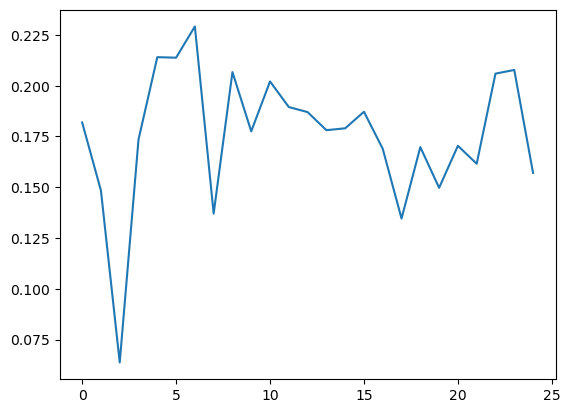

In [33]:
plt.plot(score_cache_linear)

Text(0.5, 1.0, 'Linear SWQB Polynomial Hyper Parameter Search')

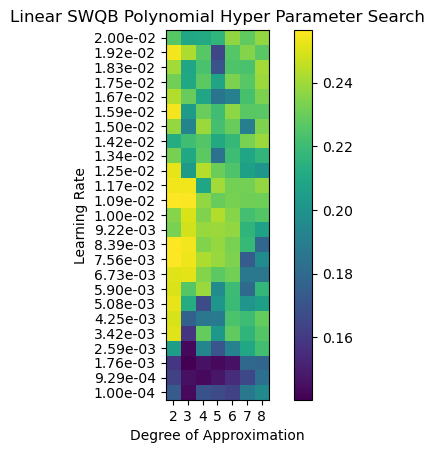

In [34]:
plt.imshow(score_cache_linear_AK)
plt.colorbar()
y_ticks = test_LR.cpu().numpy()
# round 
y_ticks = [ "{:.2e}".format(y) for y in y_ticks ]

plt.xticks(range(len(test_degree_approximation)), test_degree_approximation.cpu().numpy())
plt.yticks(range(len(test_LR)), y_ticks)
plt.xlabel("Degree of Approximation")
plt.ylabel("Learning Rate")
plt.title("Linear SWQB Polynomial Hyper Parameter Search")

Text(0.5, 1.0, 'Linear SWQB Cosine Hyper Parameter Search')

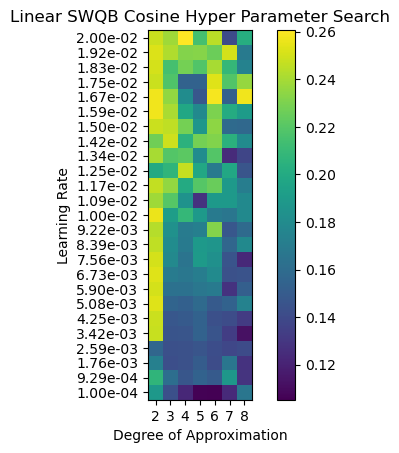

In [35]:
plt.imshow(score_cache_linear_AK_fourier)
plt.colorbar()
y_ticks = test_LR.cpu().numpy()
# round 
y_ticks = [ "{:.2e}".format(y) for y in y_ticks ]

plt.xticks(range(len(test_degree_approximation)), test_degree_approximation.cpu().numpy())
plt.yticks(range(len(test_LR)), y_ticks)
plt.xlabel("Degree of Approximation")
plt.ylabel("Learning Rate")
plt.title("Linear SWQB Cosine Hyper Parameter Search")

Text(0.5, 1.0, 'Deep Q Network Hyper Parameter Search')

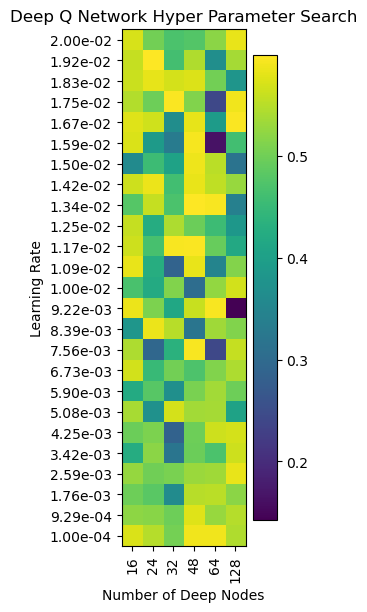

In [36]:
# make 

fig = plt.figure(figsize=(2,12))

plt.imshow(np.power(score_cache_DQ,1))
plt.colorbar( )
y_ticks = test_LR.cpu().numpy()
# round 
y_ticks = [ "{:.2e}".format(y) for y in y_ticks ]


plt.xticks(range(len(test_DEEP_NODES)), test_DEEP_NODES.cpu().numpy(), rotation=90)
plt.yticks(range(len(test_LR)), y_ticks)
plt.xlabel("Number of Deep Nodes")
plt.ylabel("Learning Rate")

plt.title("Deep Q Network Hyper Parameter Search")


Degree: 2
0.6065073
Degree: 3
0.60153776
Degree: 4
0.60342675
Degree: 5
0.60112613
Degree: 6
0.6023882
Degree: 7
0.60295707
Degree: 8
0.6016115


Text(0.5, 0.98, 'Deep Polynomial SWQB Model Hyper Parameter Search for different Degrees of Approximation (Scores raised to power 50)')

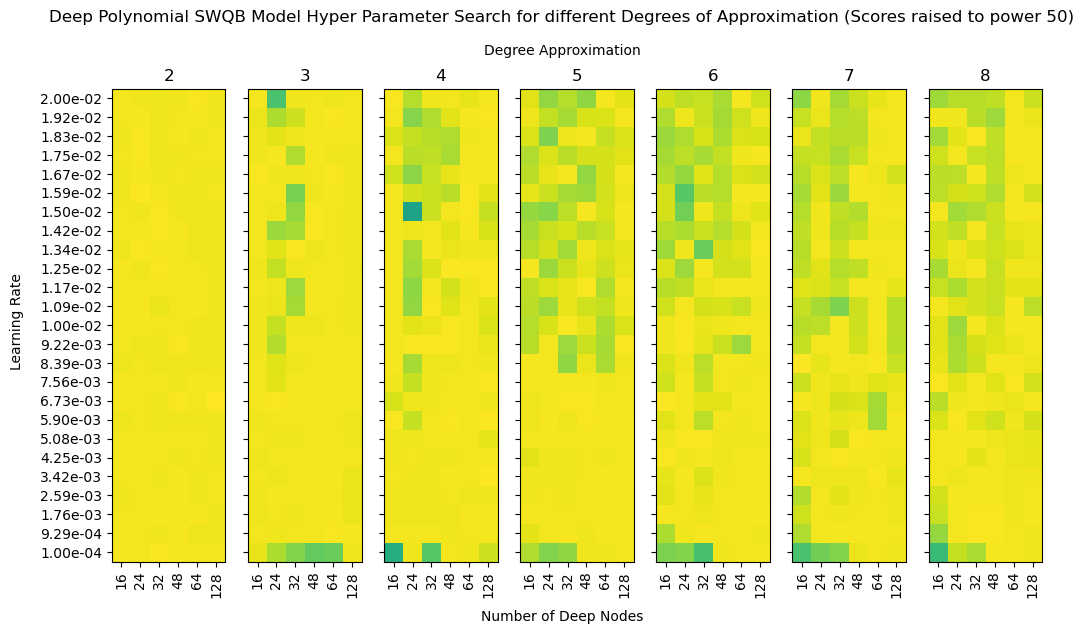

In [37]:
power = 1

min_score = 0
max_score = np.max(score_cache_DQAK)**power

f, axarr = plt.subplots(1,len(test_degree_approximation), sharey=True, figsize=(12, 6.5), sharex=True,)

for i, degree in enumerate(test_degree_approximation):
	print(f"Degree: {degree}")
	# print max score
	print(np.max(score_cache_DQAK[:,i,:]))

	axarr[i].imshow(np.power(score_cache_DQAK[:,i,:], power), vmin=min_score, vmax=max_score, cmap="viridis")
	# axarr[i].xlabel("Deep Nodes")
	# axarr[i].ylabel("Learning Rate")

	y_ticks = test_LR.cpu().numpy()
	# round 
	y_ticks = [ "{:.2e}".format(y) for y in y_ticks ]

	

	axarr[i].set_title(degree.cpu().detach().item())

	for tick in axarr[i].get_xticklabels():
		tick.set_rotation(90)

	plt.xticks(range(len(test_DEEP_NODES)), test_DEEP_NODES.cpu().numpy(), rotation=90)
	plt.yticks(range(len(test_LR)), y_ticks)

f.text(0.5, 0.04, 'Number of Deep Nodes', ha='center')
f.text(0.04, 0.5, 'Learning Rate', va='center', rotation='vertical')
f.text(0.5, 0.91, f"Degree Approximation", ha='center')

# title
f.suptitle("Deep Polynomial SWQB Model Hyper Parameter Search for different Degrees of Approximation (Scores raised to power 50)")

Degree: 2
0.60665935
Degree: 3
0.60537
Degree: 4
0.6034693
Degree: 5
0.60098255
Degree: 6
0.6013295
Degree: 7
0.60043454
Degree: 8
0.59974295


Text(0.5, 0.98, 'Deep Cosine SWQB Model Hyper Parameter Search for different Degrees of Approximation (Scores raised to power 50)')

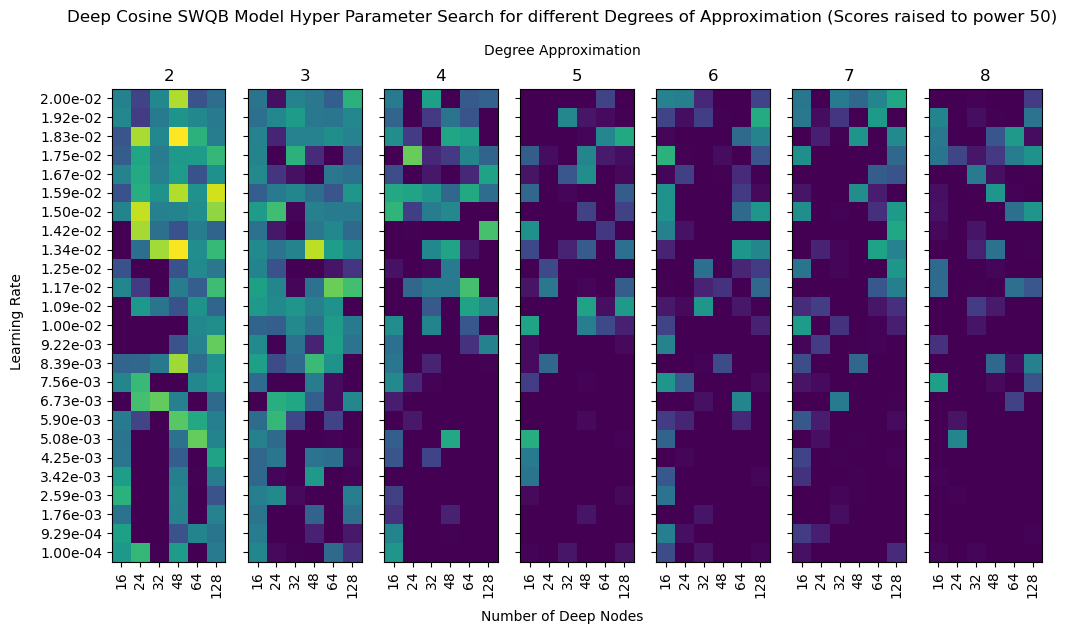

In [38]:
power = 50

min_score = 0
max_score = np.max(score_cache_DQAK_forier)**power

f, axarr = plt.subplots(1,len(test_degree_approximation), sharey=True, figsize=(12, 6.5), sharex=True,)

for i, degree in enumerate(test_degree_approximation):
	print(f"Degree: {degree}")
	# print max score
	print(np.max(score_cache_DQAK_forier[:,i,:]))

	axarr[i].imshow(np.power(score_cache_DQAK_forier[:,i,:], power), vmin=min_score, vmax=max_score, cmap="viridis")
	# axarr[i].xlabel("Deep Nodes")
	# axarr[i].ylabel("Learning Rate")

	y_ticks = test_LR.cpu().numpy()
	# round 
	y_ticks = [ "{:.2e}".format(y) for y in y_ticks ]

	

	axarr[i].set_title(degree.cpu().detach().item())

	for tick in axarr[i].get_xticklabels():
		tick.set_rotation(90)

	plt.xticks(range(len(test_DEEP_NODES)), test_DEEP_NODES.cpu().numpy(), rotation=90)
	plt.yticks(range(len(test_LR)), y_ticks)

f.text(0.5, 0.04, 'Number of Deep Nodes', ha='center')
f.text(0.04, 0.5, 'Learning Rate', va='center', rotation='vertical')
f.text(0.5, 0.91, f"Degree Approximation", ha='center')

# title
f.suptitle("Deep Cosine SWQB Model Hyper Parameter Search for different Degrees of Approximation (Scores raised to power 50)")

In [39]:
# argmax of scores
linear_i_lr = np.unravel_index(np.argmax(score_cache_linear), score_cache_linear.shape)
linear_best_lr = test_LR[linear_i_lr]
linear_best_score = score_cache_linear[linear_i_lr]

linear_AK_i_lr, linear_AK_i_degree = np.unravel_index(np.argmax(score_cache_linear_AK), score_cache_linear_AK.shape)
linear_AK_best_lr = test_LR[linear_AK_i_lr]
linear_AK_best_degree = test_degree_approximation[linear_AK_i_degree]
linear_AK_best_score = score_cache_linear_AK[linear_AK_i_lr, linear_AK_i_degree]

linear_AK_fourier_i_lr, linear_AK_fourier_i_degree = np.unravel_index(np.argmax(score_cache_linear_AK_fourier), score_cache_linear_AK_fourier.shape)
linear_AK_fourier_best_lr = test_LR[linear_AK_fourier_i_lr]
linear_AK_fourier_best_degree = test_degree_approximation[linear_AK_fourier_i_degree]
linear_AK_fourier_best_score = score_cache_linear_AK[linear_AK_fourier_i_lr, linear_AK_fourier_i_degree]

DQ_i_lr, DQ_i_deep = np.unravel_index(np.argmax(score_cache_DQ), score_cache_DQ.shape)
DQ_best_lr = test_LR[DQ_i_lr]
DQ_best_deep = test_DEEP_NODES[DQ_i_deep]
DQ_best_score = score_cache_DQ[DQ_i_lr, DQ_i_deep]

DQAK_i_lr, DQAK_i_degree, DQAK_i_deep = np.unravel_index(np.argmax(score_cache_DQAK), score_cache_DQAK.shape)
DQAK_best_lr = test_LR[DQAK_i_lr]
DQAK_best_degree = test_degree_approximation[DQAK_i_degree]
DQAK_best_deep = test_DEEP_NODES[DQAK_i_deep]
DQAK_best_score = score_cache_DQAK[DQAK_i_lr, DQAK_i_degree, DQAK_i_deep]

DQAK_forier_i_lr, DQAK_forier_i_degree, DQAK_forier_i_deep = np.unravel_index(np.argmax(score_cache_DQAK_forier), score_cache_DQAK_forier.shape)
DQAK_forier_best_lr = test_LR[DQAK_forier_i_lr]
DQAK_forier_best_degree = test_degree_approximation[DQAK_forier_i_degree]
DQAK_forier_best_deep = test_DEEP_NODES[DQAK_forier_i_deep]
DQAK_forier_best_score = score_cache_DQAK_forier[DQAK_forier_i_lr, DQAK_forier_i_degree, DQAK_forier_i_deep]

In [40]:
print(f"Linear Best Score: \t{linear_best_score: .4f} \t at LR: {linear_best_lr: .3e}")
print(f"Linear AK Best Score: \t{linear_AK_best_score: .4f} \t at LR: {linear_AK_best_lr: .3e} and Degree: {linear_AK_best_degree}")
print(f"DQ Best Score: \t\t{DQ_best_score: .4f} \t at LR: {DQ_best_lr: .3e} and Deep Nodes: {DQ_best_deep}")
print(f"DQ AK Best Score: \t{DQAK_best_score: .4f} \t at LR: {DQAK_best_lr: .3e} and Degree: {DQAK_best_degree} and Deep Nodes: {DQAK_best_deep}")
print(f"DQ AK Forier Best Score: \t{DQAK_forier_best_score: .4f} \t at LR: {DQAK_forier_best_lr: .3e} and Degree: {DQAK_forier_best_degree} and Deep Nodes: {DQAK_forier_best_deep}")

# latex table
print(f"Linear & {linear_best_score: .4f} & {linear_best_lr: .3e} \\\\")
print(f"Linear SWQB & {linear_AK_best_score: .4f} & {linear_AK_best_lr: .3e} & {linear_AK_best_degree} \\\\")
print(f"Linear SWQB Fourier & {linear_AK_fourier_best_score: .4f} & {linear_AK_fourier_best_lr: .3e} & {linear_AK_fourier_best_degree} \\\\")
print(f"Deep Q & {DQ_best_score: .4f} & {DQ_best_lr: .3e} & {DQ_best_deep} \\\\")
print(f"Deep SWQB & {DQAK_best_score: .4f} & {DQAK_best_lr: .3e} & {DQAK_best_degree} & {DQAK_best_deep} \\\\")
print(f"Deep SWQB Fourier & {DQAK_forier_best_score: .4f} & {DQAK_forier_best_lr: .3e} & {DQAK_forier_best_degree} & {DQAK_forier_best_deep} \\\\")



Linear Best Score: 	 0.2292 	 at LR:  1.502e-02
Linear AK Best Score: 	 0.2565 	 at LR:  7.562e-03 and Degree: 2
DQ Best Score: 		 0.5989 	 at LR:  1.337e-02 and Deep Nodes: 48
DQ AK Best Score: 	 0.6065 	 at LR:  6.733e-03 and Degree: 2 and Deep Nodes: 128
DQ AK Forier Best Score: 	 0.6067 	 at LR:  1.834e-02 and Degree: 2 and Deep Nodes: 48
Linear &  0.2292 &  1.502e-02 \\
Linear SWQB &  0.2565 &  7.562e-03 & 2 \\
Linear SWQB Fourier &  0.2113 &  2.000e-02 & 4 \\
Deep Q &  0.5989 &  1.337e-02 & 48 \\
Deep SWQB &  0.6065 &  6.733e-03 & 2 & 128 \\
Deep SWQB Fourier &  0.6067 &  1.834e-02 & 2 & 48 \\


(0.59, 0.66)

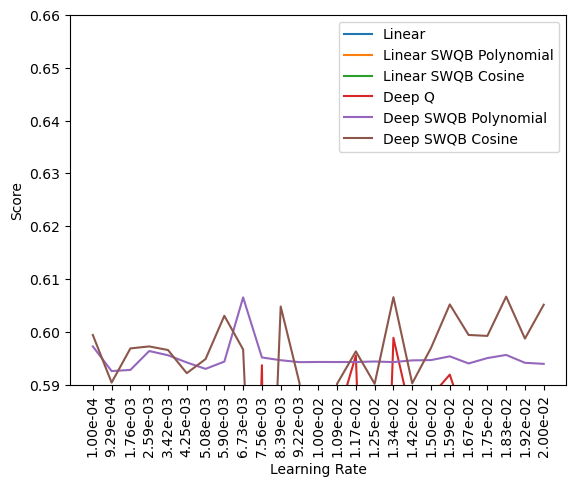

In [41]:
# Plot score to LR fixing other best variables

plt.plot(test_LR.cpu().numpy(), score_cache_linear[:])
plt.plot(test_LR.cpu().numpy(), score_cache_linear_AK[:,linear_AK_i_degree])
plt.plot(test_LR.cpu().numpy(), score_cache_linear_AK[:,linear_AK_fourier_i_degree])
plt.plot(test_LR.cpu().numpy(), score_cache_DQ[:,DQ_i_deep])
plt.plot(test_LR.cpu().numpy(), score_cache_DQAK[:,DQAK_i_degree, DQAK_i_deep])
plt.plot(test_LR.cpu().numpy(), score_cache_DQAK_forier[:,DQAK_forier_i_degree, DQAK_forier_i_deep])
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.xticks(test_LR.cpu().numpy(), [ "{:.2e}".format(x) for x in test_LR.cpu().numpy() ], rotation=90)
plt.legend(["Linear", "Linear SWQB Polynomial", "Linear SWQB Cosine", "Deep Q", "Deep SWQB Polynomial", "Deep SWQB Cosine",])
plt.ylim(.59,.66)


In [42]:
print("# Linear Hyperparameters:")
print("linear_best_lr = ", linear_best_lr.cpu().item())
print("# Linear AK Hyperparameters:")
print("linear_AK_best_lr = ", linear_AK_best_lr.cpu().item())
print("linear_AK_best_degree = ", linear_AK_best_degree.cpu().item())
print("# Linear AK Fourier Hyperparameters:")
print("linear_AK_fourier_best_lr = ", linear_AK_fourier_best_lr.cpu().item())
print("linear_AK_fourier_best_degree = ", linear_AK_fourier_best_degree.cpu().item())
print("# DQ Hyperparameters:")
print("DQ_best_lr = ", DQ_best_lr.cpu().item())
print("DQ_best_deep = ", DQ_best_deep.cpu().item())
print("# DQAK Hyperparameters:")
print("DQAK_best_lr = ", DQAK_best_lr.cpu().item())
print("DQAK_best_degree = ", DQAK_best_degree.cpu().item())
print("DQAK_best_deep = ", DQAK_best_deep.cpu().item())
print("# DQAK Forier Hyperparameters:")
print("DQAK_forier_best_lr = ", DQAK_forier_best_lr.cpu().item())
print("DQAK_forier_best_degree = ", DQAK_forier_best_degree.cpu().item())
print("DQAK_forier_best_deep = ", DQAK_forier_best_deep.cpu().item())

# Linear Hyperparameters:
linear_best_lr =  0.015024999156594276
# Linear AK Hyperparameters:
linear_AK_best_lr =  0.007562499959021807
linear_AK_best_degree =  2
# Linear AK Fourier Hyperparameters:
linear_AK_fourier_best_lr =  0.019999999552965164
linear_AK_fourier_best_degree =  4
# DQ Hyperparameters:
DQ_best_lr =  0.013366665691137314
DQ_best_deep =  48
# DQAK Hyperparameters:
DQAK_best_lr =  0.006733333226293325
DQAK_best_degree =  2
DQAK_best_deep =  128
# DQAK Forier Hyperparameters:
DQAK_forier_best_lr =  0.0183416660875082
DQAK_forier_best_degree =  2
DQAK_forier_best_deep =  48
